# Social Media and Data Science - Part 4

### Goal: Use social media posts to explore the appplication of text and natural language processing to see what might be learned from online interactions.

Specifically, we will retrieve, annotate, process, and interpret Twitter data on health-related issues such as smoking.

--- 
References:
* [Mining Twitter Data with Python (Part 1: Collecting data)](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)
* The [Tweepy Python API for Twitter](http://www.tweepy.org/)

Required Software
* [Python 3](https://www.python.org)
* [NumPy](http://www.numpy.org) - for preparing data for plotting
* [Matplotlib](https://matplotlib.org) - plots and garphs
* [jsonpickle](https://jsonpickle.github.io) for storing tweets. 
---

In [1]:
%matplotlib inline

import operator
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import jsonpickle
import json
import random
import tweepy
import spacy
import time
from datetime import datetime
from spacy.symbols import ORTH, LEMMA, POS

# 4.0 Introduction

Picking up where  [Part 3](SocialMedia - Part 3.ipynb) left off, this module introduces basics of classification of textual content, using classifiers from the popular [Scikit-learn](http://scikit-learn.org/stable/index.html) machine-learning tools. 

# 4.0.1 Setup

As before, we start with the Tweets class and the configuration for our Twitter API connection.  We may not need this, but we'll load it in any case.

In [2]:
class Tweets:
    
    
    def __init__(self,term="",corpus_size=100):
        self.tweets={}
        if term !="":
            self.searchTwitter(term,corpus_size)
                
    def searchTwitter(self,term,corpus_size):
        searchTime=datetime.now()
        while (self.countTweets() < corpus_size):
            new_tweets = api.search(term,lang="en",count=10)
            for nt_json in new_tweets:
                nt = nt_json._json
                if self.getTweet(nt['id_str']) is None and self.countTweets() < corpus_size:
                    self.addTweet(nt,searchTime,term)
            time.sleep(5)
                
    def addTweet(self,tweet,searchTime,term="",count=0):
        id = tweet['id_str']
        if id not in self.tweets.keys():
            self.tweets[id]={}
            self.tweets[id]['tweet']=tweet
            self.tweets[id]['count']=0
            self.tweets[id]['searchTime']=searchTime
            self.tweets[id]['searchTerm']=term
        self.tweets[id]['count'] = self.tweets[id]['count'] +1
        
    def getTweet(self,id):
        if id in self.tweets:
            return self.tweets[id]['tweet']
        else:
            return None
    
    def getTweetCount(self,id):
        return self.tweets[id]['count']
    
    def countTweets(self):
        return len(self.tweets)
    
    # return a sorted list of tupes of the form (id,count), with the occurrence counts sorted in decreasing order
    def mostFrequent(self):
        ps = []
        for t,entry in self.tweets.items():
            count = entry['count']
            ps.append((t,count))  
        ps.sort(key=lambda x: x[1],reverse=True)
        return ps
    
    # reeturns tweet IDs as a set
    def getIds(self):
        return set(self.tweets.keys())
    
    # save the tweets to a file
    def saveTweets(self,filename):
        json_data =jsonpickle.encode(self.tweets)
        with open(filename,'w') as f:
            json.dump(json_data,f)
    
    # read the tweets from a file 
    def readTweets(self,filename):
        with open(filename,'r') as f:
            json_data = json.load(f)
            incontents = jsonpickle.decode(json_data)   
            self.tweets=incontents
        
    def getSearchTerm(self,id):
        return self.tweets[id]['searchTerm']
    
    def getSearchTime(self,id):
        return self.tweets[id]['searchTime']
    
    def getText(self,id):
        tweet = self.getTweet(id)
        text=tweet['full_text']
        if 'retweeted_status'in tweet:
            original = tweet['retweeted_status']
            text=original['full_text']
        return text
                
    def addCode(self,id,code):
        tweet=self.getTweet(id)
        if 'codes' not in tweet:
            tweet['codes']=set()
        tweet['codes'].add(code)
        
   
    def addCodes(self,id,codes):
        for code in codes:
            self.addCode(id,code)
        
 
    def getCodes(self,id):
        tweet=self.getTweet(id)
        return tweet['codes']
    
    # NEW -ROUTINE TO GET PROFILE
    def getCodeProfile(self):
        summary={}
        for id in self.tweets.keys():
            tweet=self.getTweet(id)
            if 'codes' in tweet:
                for code in tweet['codes']:
                    if code not in summary:
                            summary[code] =0
                    summary[code]=summary[code]+1
        sortedsummary = sorted(summary.items(),key=operator.itemgetter(0),reverse=True)
        return sortedsummary

*REDACT FOLLOWING DETAILS*

In [3]:
consumer_key='D2L4YZ2YrO1PMix7uKUK63b8H'
consumer_secret='losRw9T8zb6VT3TEJ9JHmmhAmn1GXKVj30dkiMv9vjhXuiWek9'
access_token='15283934-iggs1hiZAPI2o5sfHWMfjumTF7SvytHPjpPRGf3I6'
access_secret='bOvqssxS97PGPwXHQZxk83KtAcDyLhRLgdQaokCdVvwFi'

In [4]:
from tweepy import OAuthHandler

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

We will also load some routines that we defined in [Part 3](SocialMedia - Part 3.ipynb):
    
1. Our routine for creating a customized NLP pipeline
2. Our routine for including tokens
3. The `filterTweetTokens` routine defined in an exercise (Without the inclusion of named entities. It will be easier to leave them out for now).

In [5]:
def getTwitterNLP():
    nlp = spacy.load('en')
    
    for word in nlp.Defaults.stop_words:
        lex = nlp.vocab[word]
        lex.is_stop = True
    
    special_case = [{ORTH: u'e-cigarette', LEMMA: u'e-cigarette', POS: u'NOUN'}]
    nlp.tokenizer.add_special_case(u'e-cigarette', special_case)
    nlp.tokenizer.add_special_case(u'E-cigarette', special_case)
    vape_case = [{ORTH: u'vape',LEMMA:u'vape',POS: u'NOUN'}]
    
    vape_spellings =[u'vap',u'vape',u'vaping',u'vapor',u'Vap',u'Vape',u'Vapor',u'Vapour']
    for v in vape_spellings:
        nlp.tokenizer.add_special_case(v, vape_case)
    def hashtag_pipe(doc):
        merged_hashtag = True
        while merged_hashtag == True:
            merged_hashtag = False
            for token_index,token in enumerate(doc):
                if token.text == '#':
                    try:
                        nbor = token.nbor()
                        start_index = token.idx
                        end_index = start_index + len(token.nbor().text) + 1
                        if doc.merge(start_index, end_index) is not None:
                            merged_hashtag = True
                            break
                    except:
                        pass
        return doc
    nlp.add_pipe(hashtag_pipe,first=True)
    return nlp

def includeToken(tok):
    val =False
    if tok.is_stop == False:
        if tok.is_alpha == True: 
            if tok.text =='RT':
                val = False
            elif tok.pos_=='NOUN' or tok.pos_=='PROPN' or tok.pos_=='VERB':
                val = True
        elif tok.text[0]=='#' or tok.text[0]=='@':
            val = True
    if val== True:
        stripped =tok.lemma_.lower().strip()
        if len(stripped) ==0:
            val = False
        else:
            val = stripped
    return val

def filterTweetTokens(tokens):
    filtered=[]
    for t in tokens:
        inc = includeToken(t)
        if inc != False:
            filtered.append(inc)
    return filtered

We will start things off by reading in our two stored sets of tweets, and creating an NLP object of processing the tweets:

In [6]:
vaping=Tweets()
vaping.readTweets("tweets-vaping.json")
print("Number of vaping tweets: "+str(vaping.countTweets()))
smoking=Tweets()
smoking.readTweets("tweets-smoking.json")
print("Number of smoking tweets: "+str(smoking.countTweets()))

Number of vaping tweets: 100
Number of smoking tweets: 100


Finally, we will include some additional modules from Scikit-Learn:

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
import string
import re

# 4.0.2 An outline for classification


Our goal is to use these smoking and vaping texts to build a classifier. For illustration purposes, we're going to make this artificially simple - we will combine the two datasets retrieved given different search terms ('smoking' and 'vaping') and we'll see if we can build a classifier that accurately distinguishes between the two. 

This *should* be a slam-dunk, but it's a good place to start to debug a pipeline. If we can't get this right, we must be missing something.

To do this, we mus go through several steps:om text will address several key tasks:
    
1. Vectorization: Converting text into numerical representations appropriate for machine learning algorithms
2. Dividing a dataset into test and train sets. 
3. Training, and evaluating a classifier

We'll also touch on a couple of key tasks that might be important for more realistic NLP tasks, which you'll try to tackle as an exercise:

1. Cross-fold validation
2. Feature selection

Much of the discussion below is informed by Nic Schrading's [Intro to NLP with spaCy](https://nicschrading.com/project/Intro-to-NLP-with-spaCy/) and the [scikit-learn Working with Text data tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#extracting-features-from-text-files).

# 4.1 Vectorization: converting text into numerical representation

Even when tokenzied, tweets are little more than glorified collections of text. As machine learning algorithms used for building classifiers operate on numbers, not text, we must convert the collection of words/tokens in each tweet into an alternative form capable of encoding all of the information in a tweet in numeric form. These numeric representations can be used to calculate similarities between items, thus forming the basis for comparisons used in clustering and machine learning.


## 4.1.1 Basic vectorization
The easiest way to do this is to convert each tweet into a *vector* of numbers, one for each word that might possibly show up in any of the tweets. The entry for each word will contain the number of times that that word occurs in the given tweet. This simple representation captures enough information to distinguish between tweets, at the expense of losing some information that might prove valuable for some tasks (try to think about what information a vector might not include - we'll get back to that later).  

Fortunately, the scikit learn library makes it easy to convert tokens from a tweet into a vector.  Too see how this works, let's start with the text from a few pre-selected tweets.

In [8]:
tweet_ids=['974316600072404992','974317062372974592','974317442796208128','974316896840568833','974316873469841410']
texts=[smoking.getText(t) for t in tweet_ids]

In [9]:
texts

['Welcome to Eternity...Smoking or non smoking ? https://t.co/W9nAU7GEaQ',
 'Cochrane Podcast: Are there any smoking cessation programmes that can help adolescents to stop smoking?https://t.co/cyrRqGZmgV',
 'BTS wasnt going to disband what are u smoking. Show me where it said they were going to disband? only a few of y’all multifandom said u were going to help but we don’t even know if those really voted https://t.co/CfsHoGnxfJ',
 "@hunteroffwitch @RealRedElephant @Taz53556229 Well that's a false analogy. Cigarettes DON'T kill people laying on a table. People who smoke cigarettes are the one's doing harm to themselves. It's not Marlboro's fault, it's your fault for smoking. This is an idiotic comparison.",
 'Made a sandwich 10 min ago and been looking for it ever since then🤦🏾\u200d♂️ I gotta stop smoking😂 https://t.co/NCbNOyvZXe']

We can then take this text and run it through Scikit-learn's `CountVectorizer`, which will turn this text into a vector representation suitable for machine learning. We mut first fit and then transform the vectorizer

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer()
vectorizer.fit(texts)
vec =vectorizer.transform(texts)

The vectorizer has five rows (one for each entry) and one column for each unique term found in any of the entries.  W can see the terms by looking at the vocabulary:

In [11]:
print(vectorizer.vocabulary_)

{'welcome': 84, 'to': 79, 'eternity': 23, 'smoking': 67, 'or': 56, 'non': 50, 'https': 34, 'co': 16, 'w9nau7geaq': 81, 'cochrane': 17, 'podcast': 58, 'are': 8, 'there': 75, 'any': 7, 'cessation': 13, 'programmes': 59, 'that': 71, 'can': 12, 'help': 33, 'adolescents': 1, 'stop': 68, 'cyrrqgzmgv': 19, 'bts': 10, 'wasnt': 82, 'going': 30, 'disband': 20, 'what': 87, 'show': 64, 'me': 46, 'where': 88, 'it': 39, 'said': 62, 'they': 76, 'were': 86, 'only': 55, 'few': 28, 'of': 52, 'all': 3, 'multifandom': 48, 'but': 11, 'we': 83, 'don': 22, 'even': 24, 'know': 41, 'if': 37, 'those': 78, 'really': 60, 'voted': 80, 'cfshognxfj': 14, 'hunteroffwitch': 35, 'realredelephant': 61, 'taz53556229': 70, 'well': 85, 'false': 26, 'analogy': 5, 'cigarettes': 15, 'kill': 40, 'people': 57, 'laying': 42, 'on': 53, 'table': 69, 'who': 89, 'smoke': 66, 'the': 72, 'one': 54, 'doing': 21, 'harm': 32, 'themselves': 73, 'not': 51, 'marlboro': 45, 'fault': 27, 'your': 90, 'for': 29, 'this': 77, 'is': 38, 'an': 4, '

And we can look at the results by printing the array version of the transformed vectorizer:

In [12]:
print(vec.toarray())

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
  0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 2 1 0 0 1
  0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 2 0 1 0 1 0 0 0 1 0 3 0 0 1 1 0
  0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 2 0 1 0 0 1 0 0 0 0
  0 0 0 0 1 0 1 3 1 0 1 1 0 0 2 1 1 0 0]
 [0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 2 0 0 1 0 0 1 1 0 0 0 1 2 0 1 0 0 1 0 0 1
  1 0 1 2 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 2 0 0 0 1 0 0 0 0 1 1 0 1 1 1
  1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1]
 [1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0
  0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


To interpret this , can look at the first tweet

In [13]:
texts[0]

'Welcome to Eternity...Smoking or non smoking ? https://t.co/W9nAU7GEaQ'

Notice that the word 'smoking' has occurred two times in this tweet. We can stat by finding the position of 'smoking' in the vocabulary:

In [14]:
index = vectorizer.vocabulary_.get("smoking")
print(index)

67


so column 36 has the count for 'me'. Let's look at the value in row 0, column 67.

In [15]:
vec[0,67]

2

the count is 2, as expected! 

Try a few more examples to confirm that the counts are working. 

## 4.1.2 TF-IDF Vectorization

Vectorization by count is only one approach that we might take. However, direct counts suffer from an important shortcoming: if we leave in all of the prepositions and all other low-content words, we might see vectors that are dominated by these words, making comparisons based on more informative words more difficult.  More generally, if we have texts with very similar wods, the counts might obscure some of the key differences. 


To see how this might work, try the following experiment:

Imagine these two texts:

* "The man went to the store to by some milk."
* "The man went to the store to by some coffee."

Clearlly, the most interesting difference here is 'milk' vs. 'coffee'. Let's see what happens when we try to vectorize these texts. 

In [16]:
simtexts=["The man went to the store to buy some milk.","The man went to the store to buy some coffee."]
simvectorizer=CountVectorizer()
simvectorizer.fit(simtexts)
simvec =simvectorizer.transform(simtexts)
print(simvec.toarray())

[[1 0 1 1 1 1 2 2 1]
 [1 1 1 0 1 1 2 2 1]]


Note that these vectors are almost idenical, differing only in the second and fourth positions.  We can guess that one of these corresponds to 'milk' and the other to 'coffee'. Let's confirm:

In [17]:
print(simvectorizer.vocabulary_.get("milk"))
print(simvectorizer.vocabulary_.get("coffee"))

3
1


As expected. 

For some applications, this similarity might be fine. For others, it might be undesirable. In those cases, a different approach is needed.

Specifically, we might like to have a technique that emphasizes words that are distinctive, downplaying those that are frequently found. In the above example, we might reduce the importance of 'man', 'went', and 'store', focusing instead on'milk' and 'coffee'. 

This problem was addressed years ago by the information retrieval community, who found that searching for uncommon or distinctive words was more effective than searching for common words. This led to the development of the `term frequency/inverse document frequency' model, which uses the frequencies of words across texts to adjust the counts  of vector representation of text, by computing the product of two numbers for each term:

* The 'term frequency' is the number of times a term appears in a text divided by the total number of terms in the text.
* The 'inverse document frequency' is the logarithm of the number of documents divided by the number of documents containing the term.

The term frequency is higher for words that are used frequently in each document, while the inverse document frequency decreases as the number of documents with a term increases. The product of these terms forms the tf-idf score.  The tf-idf score applied to each term in a text (in our case, a tweet), can form a vector analogous to the count vector shown above. 

The [Wikipedia page on tf-idf](https://en.wikipedia.org/wiki/Tf–idf) provides a reasonably good overview of tf-idf scores and some common variants.

If this were an information retrieval course, the next exercise might be to write a TF-IDF vectorizer, but scikit has one ready to go. It can be used just like the CountVectorizer. 

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
simvectorizer2=TfidfVectorizer()
simvectorizer2.fit(simtexts)
simvec2 =simvectorizer2.transform(simtexts)
print(simvectorizer2.vocabulary_)
print(simvec2.toarray())

{'the': 6, 'man': 2, 'went': 8, 'to': 7, 'store': 5, 'buy': 0, 'some': 4, 'milk': 3, 'coffee': 1}
[[0.25841146 0.         0.25841146 0.36318829 0.25841146 0.25841146
  0.51682292 0.51682292 0.25841146]
 [0.25841146 0.36318829 0.25841146 0.         0.25841146 0.25841146
  0.51682292 0.51682292 0.25841146]]


If we compare this result to the previous vector, we can notice a few things. 

1. Terms that had had a weight of 1 are reduced to 0.258..
2. More frequent terms (weight of 2 -'to' and 'the' are reduced to 0.516 
3. Unique terms - 'milk' and 'coffee' still have a zero weight when they are not seen, but a higher weight when they are seen. 

This vectorization does not completely eliminate weights for the frequent terms, but it does reduce their importance relatively.  With more documents, more frequent terms would decrease further relatively. 

To see this, let's go back to the set of 5 tweets:

In [19]:
vectorizer =TfidfVectorizer()
vectorizer.fit(texts)
vec2=vectorizer.transform(texts)
print(vectorizer.vocabulary_)
print(vec2.toarray()[0])

{'welcome': 84, 'to': 79, 'eternity': 23, 'smoking': 67, 'or': 56, 'non': 50, 'https': 34, 'co': 16, 'w9nau7geaq': 81, 'cochrane': 17, 'podcast': 58, 'are': 8, 'there': 75, 'any': 7, 'cessation': 13, 'programmes': 59, 'that': 71, 'can': 12, 'help': 33, 'adolescents': 1, 'stop': 68, 'cyrrqgzmgv': 19, 'bts': 10, 'wasnt': 82, 'going': 30, 'disband': 20, 'what': 87, 'show': 64, 'me': 46, 'where': 88, 'it': 39, 'said': 62, 'they': 76, 'were': 86, 'only': 55, 'few': 28, 'of': 52, 'all': 3, 'multifandom': 48, 'but': 11, 'we': 83, 'don': 22, 'even': 24, 'know': 41, 'if': 37, 'those': 78, 'really': 60, 'voted': 80, 'cfshognxfj': 14, 'hunteroffwitch': 35, 'realredelephant': 61, 'taz53556229': 70, 'well': 85, 'false': 26, 'analogy': 5, 'cigarettes': 15, 'kill': 40, 'people': 57, 'laying': 42, 'on': 53, 'table': 69, 'who': 89, 'smoke': 66, 'the': 72, 'one': 54, 'doing': 21, 'harm': 32, 'themselves': 73, 'not': 51, 'marlboro': 45, 'fault': 27, 'your': 90, 'for': 29, 'this': 77, 'is': 38, 'an': 4, '

Let's compare this to the previous vector:

In [20]:
print(vec.toarray()[0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0]


You should be able to see a similar trend as some values are scaled up and others are scaled down.

Our goal in this section was to convert each tweet into a numeric representation suitable for use in a classifier. We've now seen two ways to do this. However, you may have noticed that we are doing this without the benefit of any of the spaCy tokenizing that we developed in [Part 3](SocialMedia - Part 3.ipynb). We'll see how we can add this back in the next section.

# 4.1.3 Vectorizing with our tokenizer

Recall from [Part 3](SocialMedia - Part 3.ipynb) that we established a set of routines to create a custom tokenizer to handle hashtags appropriately (the `getTwitterNLP` routine), a routine to only include certain types of tokens (`includeToken`), and a routine to process all tokens and add in any named entities (`filterTweetTokens`).  We'd like to find a way to build these processes in to the vectorization process. 

Fortunately, this is easy to do. To fit with the way that the scikitlearn Vectorizers work, we start by writing a routine that takes a text, calls the spaCy pipeline, and then filters the tokens:

In [21]:
def tokenizeText(text):
    nlp=getTwitterNLP()
    tokens=nlp(text)
    return filterTweetTokens(tokens)

Then, we create a vectorizer that uses this routine as the tokenizer:

In [22]:
simvectorizer3=CountVectorizer(tokenizer=tokenizeText, preprocessor=lambda x: x)
simvectorizer3.fit(texts)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function <lambda> at 0x10df88378>, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizeText at 0x10df800d0>, vocabulary=None)

*Note* the `preprocessor` argument passed to the `CountVectorizer`. This is necessary to override some of the functions in the vectorizer. 

By default, the vectorizer will perform a number of functions, including a preprocessing stage that will perform some string transformations. See the [Count Vectorizer API docs](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and the [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) for some details.

Ordinarily, this would be a fine thing to do. However, we are not interested in having scikit-learn do any preprocessing or tokenizing for us, as our `tokenizeText` routine does what we need it to do. So, we need to turn it off. To do this, we use the `preprocessor` argument, with this value:

    lambda x: x
    
which indicates an un-named procedure that will simply return the value it is provided. Using this procedure as the argument effectively turns the preprocessing step into a meaningless operation, ensuring that the `CountVectorizer` will use exactly the tokens that result from `tokenizeText`.

As before, we can look at the vocabulary

In [23]:
print(simvectorizer3.vocabulary_)

{'welcome': 39, 'eternity': 13, 'smoking': 34, 'cochrane': 9, 'podcast': 28, 'be': 5, 'cessation': 7, 'programme': 29, 'help': 18, 'adolescent': 3, 'stop': 35, 'cyrrqgzmgv': 11, 'bts': 6, 'go': 16, 'disband': 12, 'u': 37, 'show': 32, 'say': 31, 'multifandom': 26, 'know': 20, 'vote': 38, '@hunteroffwitch': 0, '@realredelephant': 1, '@taz53556229': 2, 'analogy': 4, 'cigarette': 8, 'kill': 19, 'people': 27, 'lay': 21, 'table': 36, 'smoke': 33, 'harm': 17, 'marlboro': 24, 'fault': 14, 'comparison': 10, 'make': 23, 'sandwich': 30, 'min': 25, 'look': 22, 'get': 15}


and examine the resulting TF-IDF vectors:

In [24]:
simvec3 =simvectorizer3.transform(texts)
svarray3=simvec3.toarray()
print(simvec3.toarray())

[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0
  0 0 0 1]
 [0 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1
  0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 2 0 0 0 3 0 1 0 1 0 0 0 0 0 1 0 0 0 0 2 1 0 1 0
  0 1 1 0]
 [1 1 1 0 1 0 0 0 2 0 1 0 0 0 2 0 0 1 0 1 0 1 0 0 1 0 0 2 0 0 0 0 0 1 1 0
  1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1
  0 0 0 0]]


of course, you can do something similar with a TF-IDF index. 

---
## EXERCISE 4.1: Verification of the vectorizer

How would you go about verifying the correctness of this output?  Describe a plan. You can assume, based on our prior work, that the tokenizer works well.

----
*ANSWER BELOW - CUT BELOW HERE*

Here's one possible strategy. For each text in the sample, we will do the following

1. Get the tokens for the text
2. Convert the list of tokens into a dictionary, holding the number of times each token is found.
3. We will then iterate through the tokens in that dictionary. For each one, we will do the following steps:
    
    * Find the entry in the vectorizer vocabulary.
    * Use that entry to find the corresponding entry in the array from the transformed vectorizer.
    * ensure the counts match. If they don't, note a discrepancy by storing the token and the count in a list.

In [25]:
def textToCount(text):
    toks =tokenizeText(text)
    counted={}
    for tok in toks:
        if tok not in counted:
            counted[tok]=0
        counted[tok]=counted[tok]+1
    return counted

def checkText(text,vecEntries):
    counted = textToCount(text)
    
    # now, look for these in the vocabulary
    errs=[]
    for tok,count in counted.items():
        pos = simvectorizer3.vocabulary_.get(tok)
        if pos == None:
            errs.append((tok,count))
        else:
            vecCount = vecEntries[pos]
            if vecCount!=count:
                errs.append((tok,count))
    return errs

In [26]:
text=texts[0]
ve=svarray3[0]
errs=checkText(text,ve)

In [27]:
errs

[]

In [28]:
text

'Welcome to Eternity...Smoking or non smoking ? https://t.co/W9nAU7GEaQ'

Now, we can tie it together for all of texts..

In [29]:
texts

['Welcome to Eternity...Smoking or non smoking ? https://t.co/W9nAU7GEaQ',
 'Cochrane Podcast: Are there any smoking cessation programmes that can help adolescents to stop smoking?https://t.co/cyrRqGZmgV',
 'BTS wasnt going to disband what are u smoking. Show me where it said they were going to disband? only a few of y’all multifandom said u were going to help but we don’t even know if those really voted https://t.co/CfsHoGnxfJ',
 "@hunteroffwitch @RealRedElephant @Taz53556229 Well that's a false analogy. Cigarettes DON'T kill people laying on a table. People who smoke cigarettes are the one's doing harm to themselves. It's not Marlboro's fault, it's your fault for smoking. This is an idiotic comparison.",
 'Made a sandwich 10 min ago and been looking for it ever since then🤦🏾\u200d♂️ I gotta stop smoking😂 https://t.co/NCbNOyvZXe']

In [30]:
def checkTextList(texts,vectorArray):
    errs=[]
    for i in range(len(texts)):
        text = texts[i]
        entries=vectorArray[i]
        errs_i=checkText(text,entries)
        errs.append(errs_i)
    return errs

In [31]:
checkTextList(texts,svarray3)

[[], [], [], [], []]

Looks good! No errors on the five texts in the list. 

For an added challenge, consider how you might verify the TF-IDF vectorizer. This will require recreating the calculations for the term frequency and the inverse document frequency.

*END ANSWER*

---

# 4.2 Dividing a dataset into test and train sets.

The goal of a classifier is to identify which of two (or more) sets a given piece of data belongs to - in our case 'smoking' or 'vaping'.  To do this, we build a mathematical model based on the vectorized representation of known results - so called 'training' data. We then test the accuracy of the model on a separate set of data not used in the training - the 'test'data. 

Why must these sets be different? Imagine what would happen if we used the same data to train and test. Each item in the data set would contribute to the classification, influencing the model to increase the likelihood that it would be classified correctly on the test. Thus, our test results should be very good. However, we would know nothing about how well our model would work on a new set of data.

To get around this problem, we divide the data into two sets - *train* and *test*. The *train* set will be used to build the model and the *test* set will be used to evaluate the accuracy of the results.

Before we get into the splits, we're going to do a little bit of data reshaping. 

Each of the smoking and vaping sets has tweets in the `Tweets` structure, which stores tweets in a dictionary keyed by the Tweet id, along with additional data such as the search term.  We're going to pull out those tweets into a 'flattened' structure, where pair each tweet text with the appropiate search term in a tuple.  We'll make a list of those tuples containing all of the 'smoking' and 'vaping' tweets. 

Why bother with this reshaping of the data? Easy - it's what we need to send things in to the classifier. Basically, we'll need a list of categories ('smoking' or 'vaping') and a list of the tweets to go with each category. That will be our input, for both training and testing.

Once we get the list of tuples, we'll shuffle it up and split it into two sets. 

Enough introduction. Let's get to work, with a routine to convert tweets into the simpler representation:

In [32]:
def flattenTweets(tweets):
    flat=[]
    for i in tweets.getIds():
        text = tweets.getText(i)
        cat = tweets.getSearchTerm(i) 
        pair =(text,cat)
        flat.append(pair)
    return flat

note that we simply iterate through the tweet ids, get the text and search term, pair them up, and append to the list. 

In [33]:
flatSmoke = flattenTweets(smoking)
flatSmoke[0]

('@Aland_Barwary He gotta stop smoking and take care of this nasty nails 😂 he hasn’t done his nails for 10 years',
 'smoking')

ok. looks good.

To get a test train split, we'll take a list of pairs and an optional `splitFactor`, indicating how much should go into each set. We use 80% training and 20% testing as a common default split. We randomly reorder the tweets, we use this ratio to calculate the size of the train and test segments, and we pull out desired items with appropriate list indexing.

Two things to notes here:
1. The third argument - `splitFactor=0.8` indicates a default value. If a third argument is provided it will be used as the value for the split factor. Otherwise, the factor will be 0.8.

2. `pairs[:split]` includes the first `split` items in the list, while `pairs[split:]` contains everything from `split` to the end of the list. Thus, if `split` is 80 and there are 100 items in the list, the first will contain items 0-79, and the second will contain 80-99.

In [34]:
def getTestTrainSplit(pairs,splitFactor=0.8):
    random.shuffle(pairs)
    split=int(len(pairs)*splitFactor)
    train=pairs[:split]
    test =pairs[split:]
    return train,test

In [35]:
strain,stest = getTestTrainSplit(flatSmoke)
print(str(len(strain))+ " "+str(len(stest)))

80 20


ok. looks good. Now we can tie these together in a simple routine to handle the combination of the two input sets into one:

In [36]:
def getTestTrain(smoking,vaping,splitFactor=0.8):
    fsmoke=flattenTweets(smoking)
    fvape=flattenTweets(vaping)
    tweets = fsmoke+fvape
    train,test=getTestTrainSplit(tweets,splitFactor)
    return train,test

In [37]:
train,test=getTestTrain(smoking,vaping)
print(str(len(train))+ " "+str(len(test)))

160 40


This check of the sizeso of the test and train sets provides one useful sanity check - we know that the splits are of the right size.  

However, size is only one factor. We'd like to ensure that the test and train sets both have roughly the right *distribution* of items from each set. Why does this matter?  Well, in machine learning, more is almost always better, but we need more of the right type of data. 

Imagine if the splits had gone badly, make almost all of your training data from one group and almost all of the testing data from the other. For our current data set, this kind of bad split is highly unlikely, as we're starting from two sets of equal size, but it is possible. You'd have very little information about the smaller group, and a classifier would be able to achieve reasonably good accuracy by simply always choosing the larger group. 

This is a very real problem for problems involving relatively rare classes. When one of the classes is found much more frequently than the other, the data is said to be *skewed*, and accurate classification can be very difficult. Strategies for addressing this problem include both *upsampling* - replicating data like the items found in the smaller set - and *downsampling* - removing some of the items from the larger set. Both aim at getting at least a bit closer to parity.

For now, our problem is a bit easier - we think we should be able to get a reasonably equal split. However, we'd like to verify that our sets are roughly balanced.

---
## EXERCISE 4.2: Checking for skew

Write a quick check to verify that the data splits are roughly equal - in other words, that both the test and the training set are close to 50% from each category. 


----
*ANSWER BELOW - CUT BELOW HERE*

Here's a routine that will check either list for the frequency of the categories.

In [38]:
def getSplit(itemList):
    counts={}
    for item in itemList:
        cat = item[1] # category is second in the pair.
        if cat not in counts:
            counts[cat]=0
        counts[cat]=counts[cat]+1
    count = len(itemList)
    res=[]
    for cat,c in counts.items():
        ratio = c/count
        res.append((cat,ratio))
    return res

In [39]:
trainSplit = getSplit(train)
trainSplit

[('vaping', 0.5125), ('smoking', 0.4875)]

In [40]:
testSplit = getSplit(test)
testSplit

[('smoking', 0.55), ('vaping', 0.45)]

This isn't a perfect 50/50 split, but it's far from being badly skewed. Should be good enough to move forward.

*END ANSWER*

---

Now that we've got decent train and test splits, we must go through one further, final transformation to prepare the data. Both test and train data are lists of pairs, each pair containing the tweet text and the category assigned to the tweet. For use in a classifier, we must put the data into a different form. Specifically, we need two lists: a list of texts, and a list of categories, such that the *i*th element in the category list is the category for the *i*th text. 

It's easy enough to write a routine that would do this, but we can use python's `zip` function instead.  When given a list of tuples, `zip(*tuplelist)` will return one tuple containing all of the first items, one containing all of the second items, etc. :

In [41]:
a= [(1,2,3),(4,5,6),(7,8,9)]
a0,a1,a2=zip(*a)

In [42]:
print(a0)
print(a1)
print(a2)

(1, 4, 7)
(2, 5, 8)
(3, 6, 9)


thus, we can do this for the test and train data:

In [43]:
trainTexts,trainCats=zip(*train)
testTexts,testCats=zip(*test)

# 4.3 Training a classifier

So, let's recap. We have the following pieces in place. 

1. AVectorizer that uses our custom tokenizer to build a vector representation of our texts.
2. Test and train texts with category assignments.

Now, we must train the classifier and see how well it works. 

To train and evaluate a classifier, we will put these elements together with a classifier from one of the classes provided by [scikit-learn](http://scikit-learn.org/stable/index.html).

Specifically, we'll try the [Linear Support Vector Machine Classifier](http://scikit-learn.org/stable/modules/svm.html#svm-classification). 

A support vector machine takes a number of high-dimensionsal data items (in this case, the vector representations of each of our texts), and tries to find a hyperplane that best separates the classes - essentially , trying to build a wall between the classes as best possible. For an explanation of the mathematical details, see this segment in the [opencv manual](https://docs.opencv.org/2.4/doc/tutorials/ml/introduction_to_svm/introduction_to_svm.html).

To use the Linear SVM, we will put it into a pipeline. A pipeline is a series of processing steps applied in order to each of the inputs -in this case the text and associated categories. 

Our plan here will be as follows:

1. Create an instance of the vectorizer with the chosen tokenizer.
2. Create the Linear support vector machine.
3. Construct a pipeline including these items in order:

In [44]:
vectorizer= TfidfVectorizer(tokenizer=tokenizeText,preprocessor=lambda x: x)
clf = LinearSVC()
pipe = Pipeline([('vectorizer', vectorizer), ('clf', clf)])

This creates the pipeline, saying that each element in the input list will be processed by the vectorizer and results will be classified by the Linear Support Vector Classifier. The trainsformation steps shown above are accounted for in the pipeline. Thus, two train the classifier, all we need to do is to pass in the texts and the categories:

In [45]:
pipe.fit(trainTexts,trainCats)

Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function <...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

To test the model, we can make predictions based on the texts in the test set:

In [46]:
preds = pipe.predict(testTexts)

and now our model is trained. 

and then we can use a routine provided by scikit to test the accuracy relative to the test categories:

# 4.4 Evaluating a classifier

The easiest check what we can do is to see how many of the classifications were correct. We can use the `accuracy_score` routine to see how accurate the model was.

In this sense, accuracy is just the number of items that were categorized correctly:

In [47]:
print("accuracy:", accuracy_score(testCats, preds))

accuracy: 0.975


Note that `testCats` is the list of test cateogries, `preds` is the list of predictions, and `testTexts` is the list of texts that we are testing.  We can use these lists to identify any items that were miss-classified. Of course, if the accuracy is 1, we are all set:

In [48]:
def checkResults(testCats,preds,texts):
    errs=[]
    for i in range(len(testCats)):
        if testCats[i] != preds[i]:
            errs.append((texts[i],testCats[i],preds[i]))
    return errs

checkResults(testCats,preds,testTexts)

[('Walked outside to avoid staffer wrath. Immediately took up smoking. Is there a difference between vaping and e-cigs?',
  'vaping',
  'smoking')]

One example we ran for this had the text 'Vaping: It's just as unhealthy as smoking and it makes you look like a dork.'.The test cateogry was 'vaping', but the prediction was 'smoking'. It's not hard to see how this tweet might be miscategorized.

We can use this result to verify the accuracy. First, we confirm the number of items in the test set:

In [49]:
len(testCats)

40

the accuracy will simply be the number of test items classified correctly divided by the total number of items. For the case with one error (out of 40), we had a reported accuracy of 0.975, which is equal to 39/40:

In [50]:
39/40

0.975

Beyond accuracy, we can look at two additional measures of success.  These measures are based on understanding results as being either true positive, false positive, true negative, or false negative. Specifically, if we imagine the test categories on in rows and the test results in columns, we have the following, known as a *confusion matrix*:

<table>
    <tr><td></td><td></td><td colspan=2 align="center">Predictions</td></tr>
    <tr><td></td><td></td><td>Smoking</td><td>Vaping</td></tr>
    <tr> <td rowspan=3>Test</td><td>Smoking</td><td>True Positive (TP)</td><td>False Negative(FN)</td></tr>
    <tr><td>Vaping</td><td>False Positive (FP)</td><td>True Positive (TP)</td></tr>
</table>

In this case, we arbitrarily say that we are trying to classify items in the rows as corresponding to 'Smoking', so an output of 'smoking' for an input of 'vaping' is a false positive, but an output of 'vaping' for an input of 'smoking' is a false negative.

Given these definitions, we can define two measures of success. 
    
* *Recall* is the percentage of items of a given class that were correctly classified as being members of that class. Specifically, if we look at all of the items associated with a class, both true positive (the ones that we  found) and false negative (those that we missed) , we want to find out what percentage are true positive:

$$ recall  = \frac{TP}{TP+FN}$$

* *Precision* is the number of items associated with a given class that were categorized correctly - the ratio of the correct answers (True positives) to the total number of items assigned to a class - true positives plus false positives:

$$ precision = \frac{TP}{TP+FP}$$

Note that these values are claculated relative to one or the other of the two classes - we can speak of recall or precision for smoking or vaping, but not overall (although they are closely linked).  Thus, given the above matrix, the "true positives" for smoking are in the upper left, and calculating the measures for vapig requires swapping the roles of false negative and false positive.

Related measures *sensitivity* and *specificity* are often used instead of precision to recall. Sensitivity is equivalent to recall, and specificity is the true negative rate - $TN/(TN+FP)$. See the [Wikipedia entry](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for a good explanation.  

Binary classifiers often use thresholds to determine which class to assign to any given input item. Varying these thresholds might increase recall at the expense of precision, or vice-versa. Many analyses will use the area under the receiver operating curve (AUROC) to evaluate classifier performance. See the [Wikipedia entry](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for some good background and the [scikit-learn documentation](http://scikit-learn.org/stable/modules/model_evaluation.html) for discussion of measures supported by the library. 

---
## EXERCISE 4.3: Calculating precision and recall

Given the the labels for the test set and the predictions (`testCats` and `preds`) above, along with the value of one of the categories of interest (`smoking` or `vaping`) write a routine that will calculate precision and recall, providing a tuple of the form `(precision,recall').

----
*ANSWER BELOW - CUT BELOW HERE*

In [51]:
def calcMetrics(testCats,preds,category):
    tp=0
    fp=0
    fn=0
    for i in range(len(testCats)):
        if testCats[i] == category and testCats[i] == preds[i]:
            tp = tp +1
        elif testCats[i]==category and preds[i] != category:
            fn = fn +1
        elif preds[i]==category and testCats[i] != category:
            fp = fp +1
    recall = tp/(tp+fn)
    precision=tp/(tp+fp)
    return (recall,precision)

In [52]:
print(calcMetrics(testCats,preds,'smoking'))
print(calcMetrics(testCats,preds,'vaping'))

(1.0, 0.9565217391304348)
(0.9444444444444444, 1.0)


*END ANSWER*

---

Although It's certainly a good exercise to calculate these measures by hand, scikit-learn provides some routines to make the job even easier. The routine `confusion_matrix` prints the matrix described above:

In [53]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(testCats,preds)
print(cm)

[[22  0]
 [ 1 17]]


From this matrix we can manually calculate precision and recall for smoking:

In [54]:
tp=cm[0][0]
fp=cm[1][0]
fn=cm[0][1]
smokingRecall= tp/(tp+fn)
smokingPrecision=tp/(tp+fp)
print("Smoking: recall is "+str(smokingRecall)+", "+"precision is "+str(smokingPrecision))

Smoking: recall is 1.0, precision is 0.9565217391304348


..and for vaping:

In [55]:
tp=cm[1][1]
fp=cm[0][1]
fn=cm[1][0]
vapingRecall= tp/(tp+fn)
vapingPrecision=tp/(tp+fp)
print("Vaping: recall is "+str(vapingRecall)+", "+"precision is "+str(vapingPrecision))

Vaping: recall is 0.9444444444444444, precision is 1.0


Recall and precision are generally in tension. If you want to make sure that all of your categorizations are correct (higher precision), you might be more conservative in your assignments and miss some items, which will lower your recall. Correspondingly, high recall might come if you are willing to accept some wrong answers in order to get all of the correct answers. This will lower your precision.

Some analyses use the $F_1$ score to combine both the recall and precision in one metric. $F_1$ is the harmonic mean of recall and precision:

$$F_1 = \frac{2*precision*recall}{precision+recall}$$



Thus, for smoking we have:

In [56]:
smokingF1 = 2*smokingPrecision*smokingRecall/(smokingPrecision+smokingRecall)
print("Smoking F1 is "+str(smokingF1))

Smoking F1 is 0.9777777777777777


Given predictions from a classifier, [scikit-learn](http://scikit-learn.org/stable/index.html) provides functions for calculating average precision and recall, but we must do a bit of manipulation to get them to work. These routines require numeric values for categories, as opposed to the textual categories that we have used. To get around this, we will write a routine to convert 'smoking' to +1 and 'vaping' to -1. We will then apply this to the test categories and the predictions:

In [57]:
def convertToNumeric(cats):
    nums =[]
    for c in cats:
        if c =='smoking':
            nums.append(1)
        elif c=='vaping': # we know that all entries are either 'smoking' or 'vaping'
            nums.append(-1)
    return nums

In [58]:
numCats=convertToNumeric(testCats)
numPreds=convertToNumeric(preds)

Now, if you look at `numCats` and `numPreds`, you will see numeric representations. From these, we can use scikit-learn routines to calculate precision and recall:

In [59]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("Precision is "+str(precision_score(numCats,numPreds,average=None)))
print("Recall is "+ str(recall_score(numCats,numPreds,average=None)))

Precision is [1.         0.95652174]
Recall is [0.94444444 1.        ]


These routines print the precision and recall for each class, in numeric order. Since we (arbitrarily) assigned `vaping` to -1 and `smoking` to +1, results for `vaping` are shown first in each array.

---
## EXERCISE 4.4: Experimenting with different test/train splits. 

The initial classifier above used 80% of the data to train and 20% to test.  However, we'd often like to do more with less. If we can train an effective model with significantly less than 20% of the data, we might be more confident in the model.  More generally, as colleciton of data is one of the most expensive parts of fany machine learning project, reducing the amount of test and train data is almost always desirable.

Write a routine to explore results in training with different proportions of test and train data. Build models with 10%, 20%, .. up to 90% used for test and train. Examine the accuracy, precision and recall of each, and evaluate - do you see any possibility of overfitting?  For an added challenge, use the [matplotlib library](https://matplotlib.org/) to plot accuracy, recall, and precision over each of these trials.

A quick hint - the [Numpy arange routine](https://docs.scipy.org/doc/numpy/reference/generated/numpy.arange.html) might be helpful for generating the potential values of splits (0.1-0.9).

----
*ANSWER BELOW - CUT BELOW HERE*

In [60]:
val = np.arange(0.1,1,0.1)

In [61]:
val

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [62]:
def tryTestTrainSplits(smoking,vaping):
    splitVals = np.arange(0.1,1,0.1)
    
    vectorizer= TfidfVectorizer(tokenizer=tokenizeText,preprocessor=lambda x: x)
    clf = LinearSVC()
    pipe = Pipeline([('vectorizer', vectorizer), ('clf', clf)])

    results=[]
    for split in splitVals: 
        train,test=getTestTrain(smoking,vaping,split)
        trainTexts,trainCats=zip(*train)
        testTexts,testCats=zip(*test)
        
        pipe.fit(trainTexts,trainCats)
        preds = pipe.predict(testTexts)
        accuracy =  accuracy_score(testCats, preds)
        
        numCats=convertToNumeric(testCats)
        numPreds=convertToNumeric(preds)
        precision = precision_score(numCats,numPreds,average=None)
        recall = recall_score(numCats,numPreds,average=None)
        
        result = (split,accuracy,precision,recall)
        results.append(result)
    return results

In [63]:
splitResults = tryTestTrainSplits(smoking,vaping)

In [64]:
splitResults

[(0.1,
  0.9166666666666666,
  array([0.91860465, 0.91489362]),
  array([0.90804598, 0.92473118])),
 (0.2,
  0.94375,
  array([0.92592593, 0.96202532]),
  array([0.96153846, 0.92682927])),
 (0.30000000000000004,
  0.9357142857142857,
  array([0.93055556, 0.94117647]),
  array([0.94366197, 0.92753623])),
 (0.4,
  0.9583333333333334,
  array([0.93650794, 0.98245614]),
  array([0.98333333, 0.93333333])),
 (0.5, 0.99, array([1.        , 0.98039216]), array([0.98, 1.  ])),
 (0.6,
  0.925,
  array([0.92857143, 0.92105263]),
  array([0.92857143, 0.92105263])),
 (0.7000000000000001,
  0.95,
  array([1.        , 0.89655172]),
  array([0.91176471, 1.        ])),
 (0.8, 0.925, array([1.  , 0.88]), array([0.83333333, 1.        ])),
 (0.9, 0.95, array([1.        , 0.88888889]), array([0.91666667, 1.        ]))]

Text(0,0.5,'accuracy')

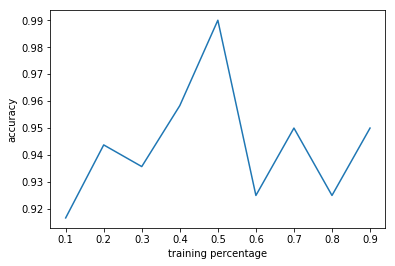

In [67]:
splits=[]
accs=[]
precs=[]
recalls=[]
for x  in splitResults:
    splits.append(x[0])
    accs.append(x[1])
    precs.append(x[2][0])
    recalls.append(x[3][0])
plt.plot(splits,accs)
plt.xlabel("training percentage")
plt.ylabel("accuracy")

Text(0,0.5,'precision')

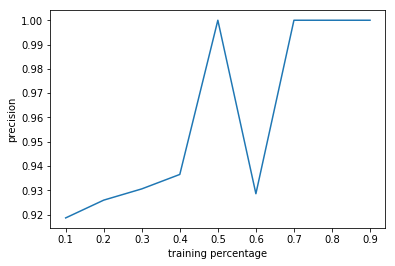

In [68]:
plt.plot(splits,precs)
plt.xlabel("training percentage")
plt.ylabel("precision")

Text(0,0.5,'recall')

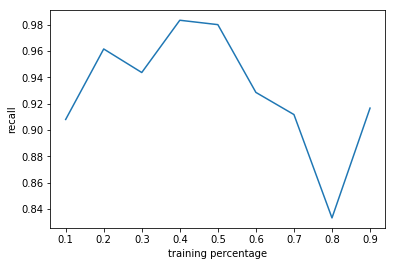

In [69]:
plt.plot(splits,recalls)
plt.xlabel("training percentage")
plt.ylabel("recall")

Note that the accuracy, precision, and recall all seem to peak when 70% of the data is used for training, followed by a dip in accuracy and recall that might suggest overfitting at 80%.

*END ANSWER*

---

---
## EXERCISE 4.5: Mixing up the labels. 

Basic classification and experiments with different test/train ratios seem to suggest that we have built a somewhat useful classifier. Let's try a different approach - what if we scramble the labels, arbitrarily assigning either `smoking` or `vaping` to each tweet?  Any classifiers built on such a model should have poor performance, as we'd essentially be removing any systematic connection between the tweets and the labels. If, on the other hand, such a model did perform well, we might wonderif we're seeing some sort of artifact and not necessarily a useful model. 

Test this theory - retrain new models based on scrambled labels. How well does this work?

----
*ANSWER BELOW - CUT BELOW HERE*

we can start with the `trainTexts` and `testTexts` defined above. 

In [70]:
print(len(trainTexts))
print(len(testTexts))

160
40


In [71]:
# generate a list of n categories
def genCats(n):
    cats=[]
    for i in range(n):
        if i%2 ==0:
            cats.append('smoking')
        else:
            cats.append('vaping')
    return cats

In [74]:
trainCats2=genCats(len(trainTexts))
testCats2=genCats(len(testTexts))
vectorizer= TfidfVectorizer(tokenizer=tokenizeText,preprocessor=lambda x: x)
clf = LinearSVC()
pipe = Pipeline([('vectorizer', vectorizer), ('clf', clf)])
pipe.fit(trainTexts,trainCats2)
preds2 = pipe.predict(testTexts)
print("accuracy:", accuracy_score(testCats2, preds))
numCats2=convertToNumeric(testCats2)
numPreds2=convertToNumeric(preds2)
print("Precision is "+str(precision_score(numCats2,numPreds2,average=None)))
print("Recall is "+ str(recall_score(numCats2,numPreds2,average=None)))

accuracy: 0.425
Precision is [0.47368421 0.47619048]
Recall is [0.45 0.5 ]


We see that this model does not perform well, as expected. With accuracy, recall, and precision at 0.5 or less, the results are about as good as 

In [ ]:
*END ANSWER*

---

# 4.5 Final Notes

[Part 5](SocialMedia - Part 5.ipynb) will finish off these exercises, with a challenge that wraps all of this together on a new data set.